# ClimateData Interface Tutorial

## A Comprehensive Guide to Using the ClimateData Class

This notebook provides a detailed walkthrough of the ClimateData interface, demonstrating how to explore available data, build queries, and retrieve climate data with various processing options.

---

## Table of Contents

1. [Getting Started](#getting-started)
2. [Understanding the Interface](#understanding-the-interface)
3. [Data Exploration](#data-exploration)
4. [Basic Data Retrieval](#basic-data-retrieval)
5. [Advanced Processing](#advanced-processing)
6. [Best Practices and Tips](#best-practices)

---

## Upfront Q&A:
- **Q: can I access station data?**
- A: no. you can't access station data yet. A larger discussion needs to be had about hosting bias-corrected data.

- **Q: can I access derived variables?**
- A: no. you can't access derived variables yet. A larger discussion needs to be had about hosting derived variables.

- **Q: does warming levels work?**
- A: no. warming levels doesn't work yet. It's a complicated thing to implement and is also going through some serious changes right now.

- **Q: can I access renewables data?**
- A: Yes! You can access all of the renewables data.

- **Q: can I access WRF and LOCA2 data from the ae catalog?**
- A: Yes! you should be able to access most of that data with limited subsetting capabilities.

- **Q: Limited subsetting capabilities? What does that mean?**
- A: I haven't implemented boundaries or station selection yet, so you can't grab some of the more convenient areas unless you happen to have your own shape file on hand.


## Getting Started

While you're reviewing this, please let me know if you find any unexpected behavior like things breaking. Or if you're adamantly opposed to how something is implemented from a UX side of things. And if you're lightly opposed that's cool too, just let me know why and we can talk it out.

Okay let's get started!

We'll start by importing the necessary libraries and initialize the ClimateData interface.

In [5]:

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Import our climate data interface
from climakitae.new_core.user_interface import ClimateData

# Initialize the interface
cd = ClimateData()

✅ Ready to query! 


The ClimateData class uses a **fluent interface pattern**, which means you can chain method calls together to build complex queries in a readable way.

---

## Understanding the Interface

### Core Concepts

The ClimateData interface organizes climate data using several key parameters:

- **`catalog`**: The main data collection (e.g., "renewables", "climate")
- **`installation`**: Specific installation type (e.g., "pv_utility", "wind_offshore")
- **`activity_id`**: Research activity (e.g., "CMIP6", "CORDEX")
- **`institution_id`**: Data provider institution (e.g., "CNRM", "DWD")
- **`source_id`**: Data source type (e.g., "GCM", "RCM")
- **`experiment_id`**: Climate experiment (e.g., "historical", "ssp245")
- **`table_id`**: Temporal resolution (e.g., "1hr", "day", "mon")
- **`grid_label`**: Spatial resolution (e.g., "d01", "d02", "d03")
- **`variable`**: Climate variable (e.g., "cf", "tasmax", "pr")
- **`processes`**: Data processing operations (clipping, time slicing, etc.)

### Method Chaining Pattern

In [ ]:
# Example of method chaining
data = (cd
    .catalog("renewables")           # Set catalog
    .installation("pv_utility")     # Set installation
    .variable("cf")                  # Set variable
    .table_id("day")                 # Set temporal resolution
    .grid_label("d03")               # Set spatial resolution
    .get()                          # Execute query
)

### Note on Concatenation

You'll see up there that the dataset was concatenated along the `sim` dimension. This dimension is created by combining `f"{source_id}_{experiment_id}"` resulting in unique simulation identifiers such as:
- WRF_TaiESM1_r1i1p1f1_historical
- WRF_MIROC6_r1i1p1f1_historical
- WRF_EC-Earth3_r1i1p1f1_historical
- WRF_MPI-ESM1-2-HR_r3i1p1f1_ssp370
- WRF_TaiESM1_r1i1p1f1_ssp370
- WRF_EC-Earth3_r1i1p1f1_ssp370
- WRF_MPI-ESM1-2-HR_r3i1p1f1_historical
- WRF_ERA5_reanalysis
- WRF_MIROC6_r1i1p1f1_ssp370

---

## Data Exploration

Before retrieving data, it's essential to explore what's available. The ClimateData interface provides several methods for this purpose.

### 1. Exploring All Available Options

In [ ]:
# Get a comprehensive overview of all available options
cd.show_all_options()

This will display all available catalogs, installations, variables, and other parameters.

### 2. Step-by-Step Exploration

Let's explore options systematically, building our query step by step:

In [ ]:
# Start by exploring available catalogs
cd.show_catalog_options()

In [ ]:
# Choose a catalog and explore installations
climate_explorer = cd.catalog("renewables")
climate_explorer.show_installation_options()

In [ ]:
# Continue building the query and explore variables
climate_explorer = climate_explorer.installation("pv_utility")
climate_explorer.show_variable_options()


### 3. Contextual Exploration

The interface shows different options based on your current query context:


In [ ]:
# See how options change as we add more parameters
query_builder = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .activity_id("WRF")
)

print("=== Available experiments with current context ===")
query_builder.show_experiment_id_options()

print("\n=== Current query status ===")
query_builder.show_query()

### 4. Understanding Variable Context


In [ ]:
cd.reset()
# Variables available depend on your other selections
cd.catalog("data").table_id("1hr").show_variable_options()
print("\n" + "="*50 + "\n")
cd.catalog("data").table_id("day").show_variable_options()

In [ ]:

cd.reset()
# Different catalog = different variables
cd.catalog("data").table_id("1hr").show_variable_options()
print("\n" + "="*50 + "\n")
cd.catalog("renewables").table_id("1hr").show_variable_options()


---

## Basic Data Retrieval

### Simple Query Example

Let's retrieve some basic climate data:


In [ ]:
# Retrieve daily capacity factor data for utility-scale PV
data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("ssp")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .get()
)

data

### Working with Multiple Variables

Right now the interface does not support selecting more than one variable at a time due to the complexity of the operation. However, this may be an option in the future if dev/user demand grows.

Currently, to retrieve multiple variables it is recommended to make multiple queries. Like so:

In [ ]:
# Retrieve multiple related variables
variables_to_get = ["cf", "gen"]
datasets = {}

for var in variables_to_get:
    print(f"Retrieving {var}...")
    datasets[var] = (cd
        .catalog("renewables")
        .installation("pv_utility")
        .experiment_id("historical")
        .table_id("day")
        .grid_label("d03")
        .variable(var)
        .get()
    )

data = xr.merge(datasets.values())
print("="*50)
print(data)

## How to debug an invalid query

Here's a few examples of what can happen if you put in bad query.

### Mis-spelled

In [ ]:
data = (cd
    .catalog("renowables") # Typo in catalog name
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .get()
)
# produces a warning and an error

print(data) # you'll get None back because the dataset couldn't be constructed

In [ ]:
data = (cd
    .catalog("renewables") 
    .installation("pv_utolity") # Typo in installation name
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .get()
)
# produces a warning with suggestions and an empty dataset

print(data) 
# you'll get an empty dataset back because the dataset was constructed
# but no data (in the catalog) was found for the given query

### Catalog Entry Does Exist

In [ ]:
data = (cd
    .catalog("data")
    .activity_id("LOCA2")
    .table_id("mon") 
    .grid_label("d01") # no monthly data available for this grid resolution
    .variable("tasmax")
    .get()
)
# produces a warning and an empty dataset

# alerts user that there's a conflict between the table_id and grid_label
# and lists the available grid labels for the given table_id

# it processes the query in the order that the catalog keys are defined
# self.all_catalog_keys = { # for renewables
#     "installation": UNSET,
#     "activity_id": UNSET,
#     "institution_id": UNSET,
#     "source_id": UNSET,
#     "experiment_id": UNSET,
#     "table_id": UNSET,
#     "grid_label": UNSET,
#     "variable_id": UNSET,
# }

print(data)



---

## Advanced Processing

### Clipping and Time Slicing

The `processes` parameter allows you to apply various transformations to your data during retrieval. This is more efficient than post-processing because it happens server-side.

### 1. Geographic Clipping with Lat/Lon Bounds

Let's clip data to the Pajaro Valley region using latitude/longitude bounds:


✅ Ready to query! 
Found 4 datasets matching your query.
Checking processes ...
Querying renewables catalog with query: {'installation': 'pv_utility', 'experiment_id': ['historical'], 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Concatenated datasets along 'sim' dimension.
✅ Data retrieval successful!
=== PAJARO VALLEY CLIPPED DATA ===
Original spatial extent would be much larger
Clipped spatial extent:
Time range: 2010-01-01T00:00:00.000000000 to 2010-12-31T00:00:00.000000000
Data shape: FrozenMappingWarningOnValuesAccess({'sim': 4, 'y': 46, 'x': 39, 'time': 365})
<xarray.DataArray 'cf' (time: 365)> Size: 1kB
dask.array<mean_agg-aggregate, shape=(365,), dtype=float32, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
    sim                <U37 148B 'wrf_mpi-esm1-2-hr_r3i1p1f1_historical'
    Lambert_Conformal  int64 8B 0
  * time               (time) datetime64[ns] 3kB 2010-01-01 ... 2010-12-31
Attributes:
    data_type:             Gridded
    extended_descript

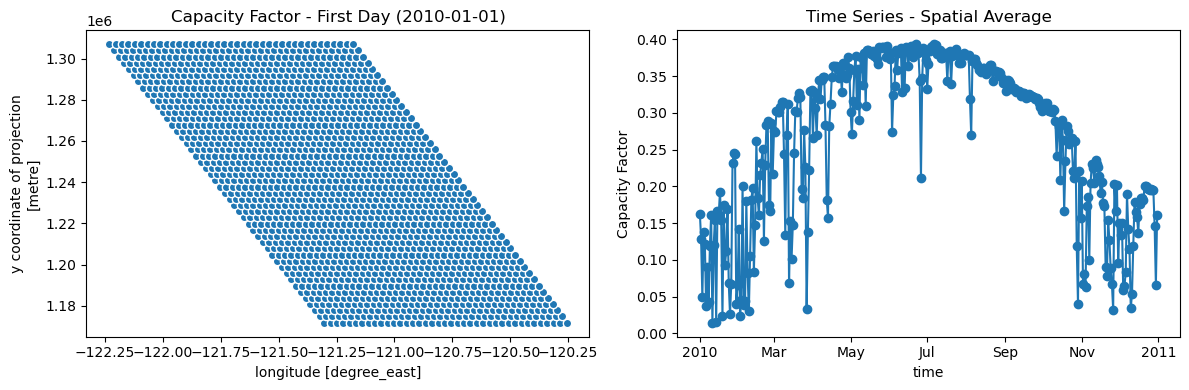

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Import our climate data interface
from climakitae.new_core.user_interface import ClimateData

# Initialize the interface
cd = ClimateData()
# Define the Pajaro Valley bounding box
pajaro_bounds = ((36.04, 37.37), (-121.43, -121.06))  # ((lat_min, lat_max), (lon_min, lon_max))

# Retrieve clipped and time-sliced data
pajaro_data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .processes({
        "time_slice": ("2010-01-01", "2010-12-31"),    # 2010 data only
        "clip": pajaro_bounds,                          # Pajaro Valley bounds
    })
    .get()
)

pajaro_data

print("=== PAJARO VALLEY CLIPPED DATA ===")
if pajaro_data is not None:
    print(f"Original spatial extent would be much larger")
    print(f"Clipped spatial extent:")
    # print(f"  Latitude: {float(pajaro_data.lat.min()):.2f} to {float(pajaro_data.lat.max()):.2f}")
    # print(f"  Longitude: {float(pajaro_data.lon.min()):.2f} to {float(pajaro_data.lon.max()):.2f}")
    print(f"Time range: {pajaro_data.time.min().values} to {pajaro_data.time.max().values}")
    print(f"Data shape: {pajaro_data.dims}")
    
    # Quick visualization
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    pajaro_data.isel(time=0).cf.plot.scatter(cmap='viridis')
    plt.title('Capacity Factor - First Day (2010-01-01)')
    
    plt.subplot(1, 2, 2)
    time_series = pajaro_data.isel(sim=0)["cf"].mean(dim=['x', 'y'])
    time_series = time_series.assign_coords(time=pd.to_datetime(time_series.time))
    print(time_series)
    time_series.plot(marker='o', linestyle='-')   
    plt.title('Time Series - Spatial Average')
    plt.ylabel('Capacity Factor')
    
    plt.tight_layout()
    plt.show()
else:
    print("Failed to retrieve data")


### 2. Geographic Clipping with Shapefile

For more complex geographic boundaries, you can use shapefiles:


In [ ]:
# Using a shapefile for clipping (more precise than bounding box)
pajaro_shapefile_data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .processes({
        "time_slice": ("2010-01-01", "2010-12-31"),        # 2010 data only
        "clip": "examples/PajaroRiverWatershed.zip",       # Shapefile path
        "concat": "sim"                                     # Concatenate simulations
    })
    .get()
)

print("=== SHAPEFILE CLIPPED DATA ===")
if pajaro_shapefile_data is not None:
    print(f"Shapefile clipping provides more precise boundaries")
    print(f"Data shape: {pajaro_shapefile_data.sizes}")
    print(f"Spatial extent:")
    print(f"  Latitude: {float(pajaro_shapefile_data.lat.values.min()):.2f} to {float(pajaro_shapefile_data.lat.values.max()):.2f}")
    print(f"  Longitude: {float(pajaro_shapefile_data.lon.min()):.2f} to {float(pajaro_shapefile_data.lon.max()):.2f}")
    
    # Compare with bounding box clipping
    if pajaro_data is not None:
        print(f"\nComparison:")
        print(f"  Bounding box points: {pajaro_data.nbytes / (1024**2):.1f} MB")
        print(f"  Shapefile points: {pajaro_shapefile_data.nbytes / (1024**2):.1f} MB")
        print(f"  Reduction: {(1 - pajaro_shapefile_data.nbytes/pajaro_data.nbytes)*100:.1f}%")

### 3. Advanced Processing Combinations

You can combine multiple processing operations:

In [ ]:
# Complex processing example
complex_data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("ssp370")          # Future scenario
    .table_id("day")                  # Monthly data
    .grid_label("d03")                # Higher resolution
    .variable("cf")
    .processes({
        # "time_slice": ("2050-01-01", "2059-12-31"),    # 2050s decade
        # "clip": ((32.0, 42.0), (-125.0, -115.0)),     # California coast
        # "concat": "sim"
    })
    .get()
)

print(complex_data)

<!-- 
### 4. Multiple Time Periods -->


In [ ]:
# Compare different time periods
time_periods = [
    ("2000-01-01", "2009-12-31", "2000s"),
    ("2010-01-01", "2019-12-31", "2010s"),
    ("2090-01-01", "2099-12-31", "2090s")
]

time_comparison = {}

for start, end, label in time_periods:
    print(f"Retrieving data for {label}...")
    time_comparison[label] = (cd
        .catalog("renewables")
        .installation("pv_utility")
        .experiment_id("ssp370" if label == "2090s" else "historical")
        .table_id("day")
        .grid_label("d03")
        .variable("cf")
        .processes({
            "time_slice": (start, end),
            "clip": pajaro_bounds,
            "concat": "sim"
        })
        .get()
    )

# Compare the periods
print("\n=== TIME PERIOD COMPARISON ===")
for period, data in time_comparison.items():
    if data is not None:
        mean_cf = float(data['cf'].mean(dim=['x','y','time','sim']))
        print(f"{period}: Mean annual capacity factor = {mean_cf:.3f}")

### 4. A-Priori Bias-Corrected Models

by default, a processor is added to the chain to remove unbiased models. This behavior can
be modified as necessary:

In [ ]:
# default behavior:
data = (cd
    .catalog("data")
    .activity_id("WRF")
    .table_id("mon")
    .grid_label("d01")
    .variable("t2max")
    .get()
)

In [ ]:
# manually include unbiased models:
data = (cd
    .catalog("data")
    .activity_id("WRF")
    .table_id("mon")
    .grid_label("d01")
    .variable("t2max")
    .processes({
        "filter_unbiased_models": "no"
    })
    .get()
)


---

## Best Practices and Tips

### 1. Query Building Strategy


In [ ]:
# Good practice: Build queries incrementally
def build_climate_query():
    """Example of systematic query building"""
    
    # Start with basic parameters
    query = cd.catalog("renewables")
    
    # Add installation based on your analysis needs
    query = query.installation("pv_utility")
    
    # Choose appropriate temporal resolution
    # - "1hr" for detailed analysis, large datasets
    # - "day" for daily patterns, medium datasets  
    # - "mon" for seasonal patterns, smaller datasets
    query = query.table_id("day")
    
    # Choose spatial resolution based on computational resources
    # - "d01": Highest resolution, largest datasets
    # - "d02": Medium resolution, good compromise
    # - "d03": Lower resolution, fastest processing
    query = query.grid_label("d03")
    
    return query

# Use the builder
base_query = build_climate_query()
base_query.show_query()

### 2. Error Handling and Debugging


In [ ]:
def safe_data_retrieval(query_func, description="data"):
    """Safely retrieve data with error handling"""
    try:
        print(f"Attempting to retrieve {description}...")
        data = query_func()
        
        if data is not None:
            print(f"✓ Successfully retrieved {description}")
            print(f"  Size: {data.nbytes / (1024**3):.1f} GB")
            print(f"  Shape: {data.dims}")
            return data
        else:
            print(f"✗ No data returned for {description}")
            return None
            
    except Exception as e:
        print(f"✗ Error retrieving {description}: {str(e)}")
        return None

# Example usage
def my_query():
    return (cd
        .catalog("renewables")
        .installation("pv_utility")
        .variable("cf")
        .table_id("day")
        .grid_label("d03")
        .get()
    )

data = safe_data_retrieval(my_query, "PV capacity factor data")

### 3. Reusing Query Configurations


In [ ]:
# Save and reuse query configurations
base_config = {
    "catalog": "renewables",
    "installation": "pv_utility", 
    "experiment_id": "historical",
    "table_id": "day",
    "grid_label": "d03"
}

# Create a fresh instance and load the configuration
query_instance = ClimateData()

# Now add variable-specific parameters
cf_data = query_instance.load_query(base_config).variable("cf").get()
temp_data = query_instance.load_query(base_config).variable("gen").get()

print(cf_data)
print(temp_data)


---

## Summary

The ClimateData interface provides a powerful and flexible way to access climate data:

### Key Features:
- **Fluent Interface**: Chain methods for readable query building
- **Progressive Exploration**: Discover available options as you build queries
- **Server-side Processing**: Efficient clipping, time slicing, and aggregation
- **Flexible Clipping**: Support for both lat/lon bounds and shapefiles
- **Error Handling**: Clear feedback when queries fail

### Best Practices:
1. **Explore First**: Use `show_*_options()` methods before building queries
2. **Process Server-side**: Use the `processes` parameter for efficiency
3. **Build Incrementally**: Add parameters step-by-step and validate
4. **Handle Errors**: Always check if data is None before processing
5. **Start Small**: Test with small datasets before scaling up

### Next Steps:
- Explore different catalogs and installations
- Experiment with various processing combinations
- Integrate with your analysis workflows
- Consider caching strategies for repeated queries

The interface makes it easy to go from exploration to analysis while handling the complexity of climate data access behind the scenes.

---

## Additional Resources

- **API Documentation**: Check the docstrings for detailed parameter information
- **Processing Options**: Use `show_processors()` to see all available processing operations
- **Validation**: Use `show_validators()` to understand data quality checks
- **Examples**: The `show_all_options()` method provides comprehensive exploration

Happy climate data analysis! 🌍📊